In [1]:
# Import standard libraries
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import seaborn as sns

# Machine learning metrics
from sklearn.metrics import classification_report, confusion_matrix

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras import Sequential, layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import InceptionV3

# # Google Colab specific imports
# from google.colab import drive

In [2]:
# # Import the drive module from Google Colab's library
# from google.colab import drive

# # Mount Google Drive to this Colab session for file access
# drive.mount('/content/drive')

In [3]:
# Set the path where your unzipped dataset is stored in your Google Drive
dataset_path = './realwaste-main/RealWaste'

# List the folders (categories) in your dataset to verify that the structure is correct
categories = os.listdir(dataset_path)
print(categories)  # This should list Paper, Plastic, etc.

# Delete DS_Store file
if '.DS_Store' in categories:
    categories.remove('.DS_Store')

['Paper', '.DS_Store', 'Metal', 'Cardboard', 'Food Organics', 'Glass', 'Vegetation', 'Textile Trash', 'Miscellaneous Trash', 'Plastic']


In [4]:
for category in categories:
  category_path = os.path.join(dataset_path, category)
  num_images = len(os.listdir(category_path))
  print(f"Category: {category}, Number of images: {num_images}")

Category: Paper, Number of images: 500
Category: Metal, Number of images: 790
Category: Cardboard, Number of images: 461
Category: Food Organics, Number of images: 411
Category: Glass, Number of images: 420
Category: Vegetation, Number of images: 436
Category: Textile Trash, Number of images: 318
Category: Miscellaneous Trash, Number of images: 495
Category: Plastic, Number of images: 921


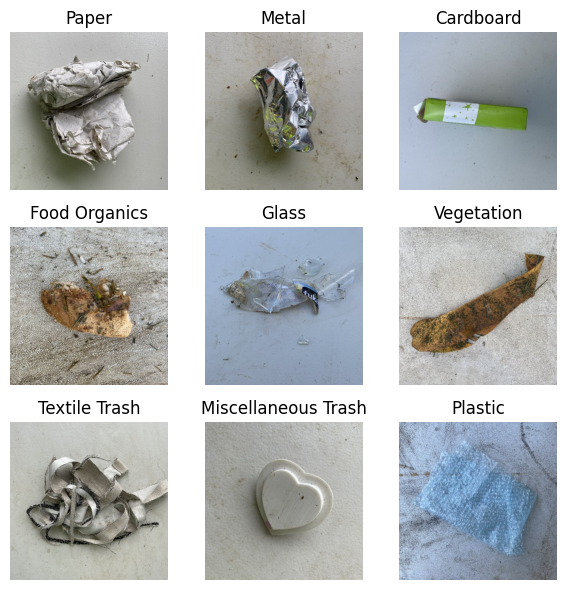

In [5]:
# Calculate the number of rows and columns for the subplot
num_categories = len(categories)
num_rows = 3  # Desired number of rows
num_cols = 3  # Desired number of columns

# Create the subplot with smaller figsize
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6))

# Flatten the axes array for easier iteration
axes = axes.ravel()

# Iterate through the categories and display images
for i, category in enumerate(categories):
    if i < num_rows * num_cols:  # Limit to the number of subplots
        category_path = os.path.join(dataset_path, category)
        image_files = os.listdir(category_path)

        # Select the first image
        first_image = image_files[0]

        image_path = os.path.join(category_path, first_image)
        image = mpimg.imread(image_path)
        axes[i].imshow(image)
        axes[i].set_title(category)
        axes[i].axis('off')
    else:
        break  # Stop if we've filled all subplots

plt.tight_layout()
plt.show()

In [6]:
# Calculate the number of rows and columns for the subplot
# num_categories = len(categories)
# num_rows = 3  # Desired number of rows
# num_cols = 3  # Desired number of columns

# # Create the subplot with smaller figsize
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))  # Reduced figsize to (10, 10)

# # Flatten the axes array for easier iteration
# axes = axes.ravel()

# # Iterate through the categories and display images
# for i, category in enumerate(categories):
#     if i < num_rows * num_cols:  # Limit to the number of subplots
#         category_path = os.path.join(dataset_path, category)
#         image_files = os.listdir(category_path)

#         # Select the first image
#         first_image = image_files[0]

#         image_path = os.path.join(category_path, first_image)
#         image = mpimg.imread(image_path)
#         axes[i].imshow(image)
#         axes[i].set_title(category)
#         axes[i].axis('off')
#     else:
#         break  # Stop if we've filled all subplots

# plt.tight_layout()
# plt.show()

In [7]:
# corrupted_images = []

# for category in categories:
#     category_path = os.path.join(dataset_path, category)
#     for image_file in os.listdir(category_path):
#         image_path = os.path.join(category_path, image_file)
#         try:
#             # Try to open and read the image
#             image = mpimg.imread(image_path)
#         except Exception as e:
#             # If there is an error, consider the image corrupted
#             print(f"Corrupted image: {image_path}")
#             corrupted_images.append(image_path)

# print(f"Total corrupted images found: {len(corrupted_images)}")

In [8]:
# # Define ImageDataGenerator with 20% data for training and 80% reserved as validation
# datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.8,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     zoom_range=0.2
# )

# # Define train_generator to use only 20% of the dataset
# train_generator = datagen.flow_from_directory(
#     dataset_path,
#     target_size=(100, 100),  # Reduced image size to save computation
#     batch_size=64,  # Increased batch size
#     class_mode='categorical',
#     subset='validation'  # 20% data subset used for training
# )

# # Define validation_generator for validation set using the remaining 80% of data
# validation_generator = datagen.flow_from_directory(
#     dataset_path,
#     target_size=(100, 100),
#     batch_size=64,
#     class_mode='categorical',
#     subset='training'  # 80% data subset used for validation
# )

# # Calculate steps per epoch based on the 20% data subset
# train_steps_per_epoch = train_generator.samples // train_generator.batch_size

In [9]:
import os
import random
import shutil
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Original dataset path (no need for a temporary subset path)
dataset_path = './realwaste-main/RealWaste'

# Set the desired image resolution (e.g., 224x224 for higher resolution)
image_resolution = (224, 224)  # Adjust as needed for your model, e.g., InceptionV3 often uses 299x299

In [10]:
# Define ImageDataGenerator with 80-20 split for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of the full dataset for validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Define train_generator using the full dataset
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_resolution,
    batch_size=64,  # Adjust batch size based on your GPU/CPU capabilities
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Define validation_generator using the full dataset
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_resolution,
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

# Calculate steps per epoch
train_steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Found 3803 images belonging to 9 classes.
Found 949 images belonging to 9 classes.
Training samples: 3803
Validation samples: 949


In [11]:
from tensorflow.keras.applications import (InceptionV3, EfficientNetB0, ResNet50, DenseNet121, Xception, MobileNetV2, NASNetMobile)
from tensorflow.keras import layers, models

def create_model(model_name, num_classes=9):
    """Creates a model based on the specified model name with default input shapes."""
    # Dictionary to map model names to their Keras applications and input shapes
    model_dict = {
        'InceptionV3': (InceptionV3, (299, 299, 3)),
        'EfficientNetB0': (EfficientNetB0, (224, 224, 3)),
        'ResNet50': (ResNet50, (224, 224, 3)),
        'DenseNet121': (DenseNet121, (224, 224, 3)),
        'Xception': (Xception, (299, 299, 3)),
        'MobileNetV2': (MobileNetV2, (224, 224, 3)),
        'NASNetMobile': (NASNetMobile, (224, 224, 3))
    }
    
    # Get the base model class and input shape from the dictionary
    model_info = model_dict.get(model_name)
    if not model_info:
        raise ValueError(f"Model '{model_name}' is not available. Choose from {list(model_dict.keys())}.")
    
    base_model_class, input_shape = model_info
    
    # Load the base model with the specified input shape
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model layers

    # Add custom classification layers on top of the base model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [12]:
def compile_model(model, optimizer='adam', loss='categorical_crossentropy'):
    """Compiles the model with the specified optimizer and loss."""
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

def train_model(model, train_generator, validation_generator, epochs=20, patience=5):
    """Trains the model with early stopping and returns the training history."""
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=epochs,
        callbacks=[early_stopping]
    )
    
    return history

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, validation_generator):
    """Evaluates the model and prints validation accuracy and loss."""
    val_loss, val_accuracy = model.evaluate(validation_generator)
    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_accuracy}")
    return val_loss, val_accuracy

def plot_training_history(history, model_name):
    """Plots training and validation accuracy and loss over epochs."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    # Accuracy plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.legend()
    plt.show()
    
    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_predictions(model, validation_generator, class_labels):
    """Displays a 3x3 grid of predictions vs. true labels."""
    images, true_labels = next(validation_generator)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(true_labels, axis=1)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        true_label = class_labels[true_labels[i]]
        predicted_label = class_labels[predicted_labels[i]]
        color = 'green' if true_label == predicted_label else 'red'
        ax.set_title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Testing model: DenseNet121
Epoch 1/20
59/59 [==============================] - 113s 2s/step - loss: 1.3605 - accuracy: 0.5237 - val_loss: 1.1606 - val_accuracy: 0.5804
Epoch 2/20
59/59 [==============================] - 108s 2s/step - loss: 0.8523 - accuracy: 0.7045 - val_loss: 1.1545 - val_accuracy: 0.6250
Epoch 3/20
59/59 [==============================] - 107s 2s/step - loss: 0.7284 - accuracy: 0.7384 - val_loss: 1.0828 - val_accuracy: 0.6194
Epoch 4/20
59/59 [==============================] - 109s 2s/step - loss: 0.6723 - accuracy: 0.7598 - val_loss: 1.0649 - val_accuracy: 0.6484
Epoch 5/20
59/59 [==============================] - 110s 2s/step - loss: 0.5971 - accuracy: 0.7820 - val_loss: 0.9859 - val_accuracy: 0.6674
Epoch 6/20
59/59 [==============================] - 106s 2s/step - loss: 0.5671 - accuracy: 0.8013 - val_loss: 0.9857 - val_accuracy: 0.6842
Epoch 7/20
59/59 [==============================] - 107s 2s/step - loss: 0.5607 - accuracy: 0.7991 - val_loss: 0.9454 - val_acc

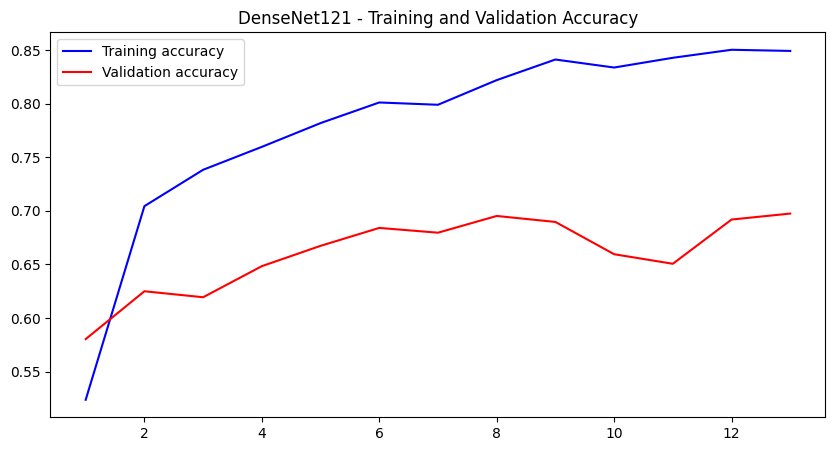

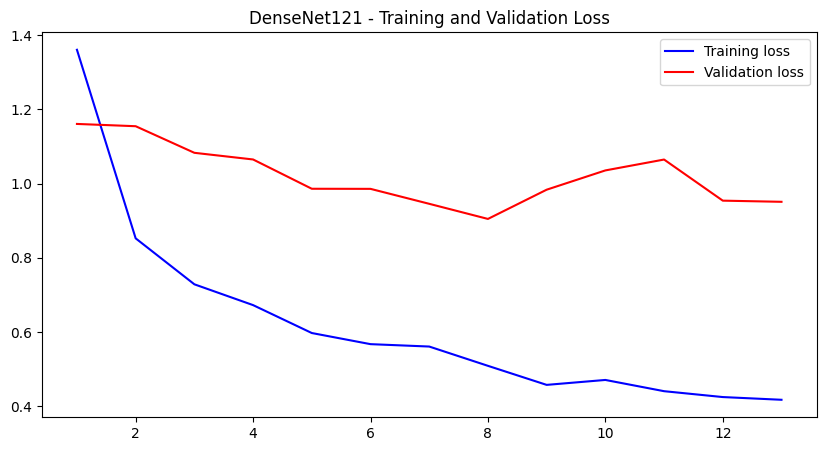

2/2 [==============================] - 2s 783ms/step


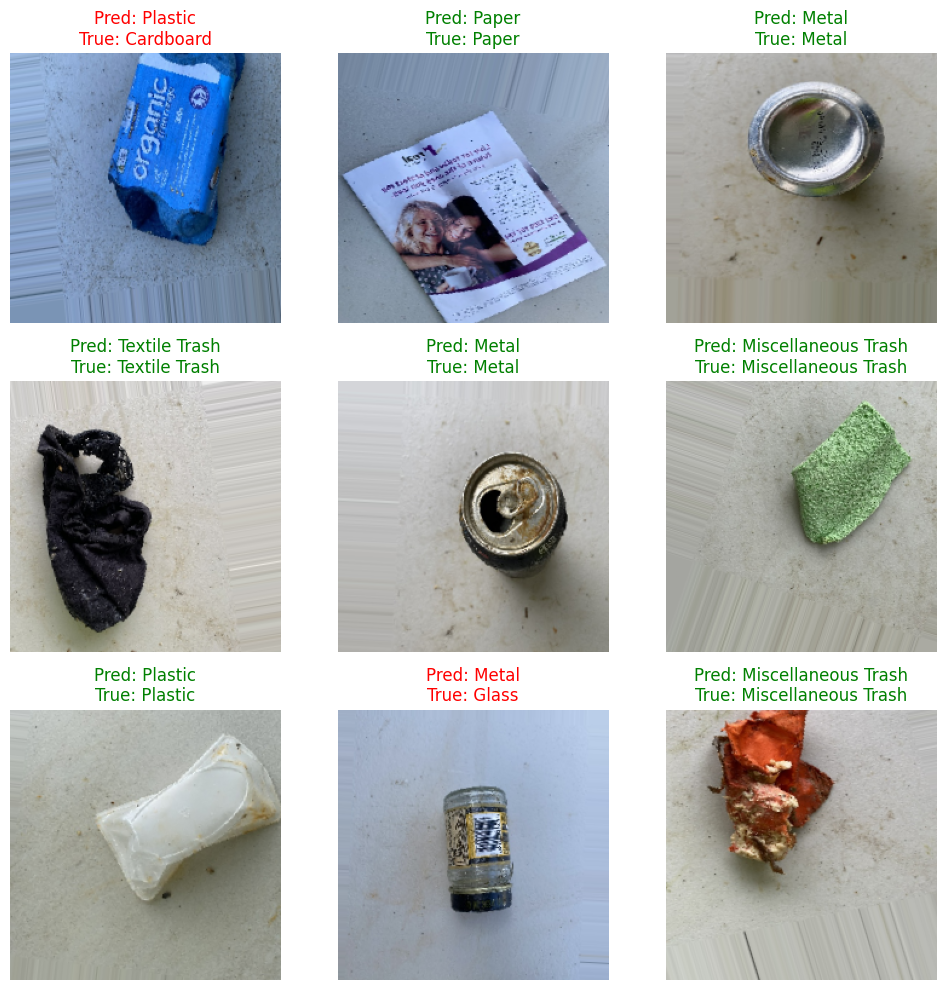

Finished testing model: DenseNet121
--------------------------------------------------


In [15]:
# List of model names to test
models_to_test = ['DenseNet121']

# Dictionary to store results
results = {}

for model_name in models_to_test:
    print(f"Testing model: {model_name}")
    
    # Create, compile, and train model
    model = create_model(model_name)
    compile_model(model)
    history = train_model(model, train_generator, validation_generator)
    
    # Evaluate model
    val_loss, val_accuracy = evaluate_model(model, validation_generator)
    results[model_name] = {'val_loss': val_loss, 'val_accuracy': val_accuracy}
    
    # Plot training history
    plot_training_history(history, model_name)
    
    # Plot predictions
    plot_predictions(model, validation_generator, list(validation_generator.class_indices.keys()))
    
    print(f"Finished testing model: {model_name}\n{'-'*50}")

In [16]:
import pandas as pd

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values(by='val_accuracy', ascending=False)  # Sort by accuracy
print("Model Comparison Results:")
print(results_df)

Model Comparison Results:
             val_loss  val_accuracy
DenseNet121  0.914138      0.697576
